In [1]:

# %%
# ## Getting Started
from pathlib import Path
from tempfile import TemporaryDirectory
from tempfile import mkdtemp

import numpy as np
import matplotlib.pyplot as plt
import flopy
import pandas as pd
import shutil
import pickle
import subprocess
import os
from random_name import generate_random_name
from datetime import datetime
import platform
# %% [markdown]

# %%

In [2]:
################### Model Parameters   ##############################
my_params = {}
my_params['name'] = 'test_wasaga_2'
## mt3dGcg
cclose=my_params['cclose'] = 1e-5
## RCT

my_params['hk'] = 6.9
my_params['vk'] = 0.1

my_params['porosity'] = 0.35
my_params['sy'] = 0.33
my_params['ss'] = 0.0002
my_params['la'] = 0.2
my_params['trpt'] = 0.1
my_params['trpv'] = 0.1
my_params['dmcoef'] = 3.7E-10 ####
my_params['sconc'] = 0.01

#Species ID
sp_ID = {}
#sp_ID['Cl-'] = 1
sp_ID['SRP'] = 1
my_params['sp_ID'] = sp_ID

#Species Name
sp_name = {}
#sp_name[1] = 'Cl-'
sp_name[1] = 'SRP'
my_params['sp_name'] = sp_name


## P lens
my_params['perlen'] = [1]+[30,92,31,212]*25 +[365]*5+[365*5]*5+[365*4]+[185,30,30,120]


## Wel data
wel_data = {}
#last_wel_id = len(my_params['perlen'])-1
for y in range(25):
    p = (y)*4 +2
    wel_data[p] = [[50,0,15,0.0075]]
    p += 1
    wel_data[p] = [[50,0,15,0.075]]
    p += 1
    wel_data[p] = [[50,0,15,0.0075]]
    p += 1
    wel_data[p] = [[50,0,15,0.0]]
    p += 1

wel_data[p] = [[50,0,15,0]]
my_params['wel_data'] = wel_data


# Mt3dSsm 
ssm_data = {}
itype = flopy.mt3d.Mt3dSsm.itype_dict()

for y in range(25):
    p = (y)*4 +2
    ssm_data[p] = [(50, 0, 15, 3000.0, itype['WEL'])]
    p += 1
    ssm_data[p] = [(50, 0, 15, 3000.0, itype['WEL'])]
    p += 1
    ssm_data[p] = [(50, 0, 15, 3000.0, itype['WEL'])]
    p += 1
    ssm_data[p] = [(50, 0, 15, 3000.0, itype['WEL'])]
    p += 1
ssm_data[p] = [(50, 0, 15, 0.0, itype['WEL'])]
my_params['ssm_data'] = ssm_data


#Mt3dBtn
mixelm=my_params['mixelm'] = 0 # HMOC
my_params['isothm'] = 3 # Langmuir
my_params['sp1'] = 0.0001 ##  0.1 mg/L  => 1e5 ug/m3
my_params['sp2'] = 0.0001  ##  maximum soil adsorption value = 100 ug/g => 1e5 ug/ug

# Rch
my_params['rech'] = 0.5/365 #0.5/365 ## 500mm/year

# dt0
my_params['dt0'] = 0.1
################################################################

base_model_my_params = my_params

In [3]:
my_params['sp1'] = 0.0002
my_params['la'] = 5
my_params['hk'] = 6.9
base_model_my_params = my_params.copy()

my_params['vk'] = 0.1
trpv=my_params['trpv'] = 0.01

In [4]:
my_params['la']

5

In [5]:
# bed size 10x10
# row: 25-35 (1m), col 12-17 (2m)
#  50 cells

In [6]:
mytop =np.loadtxt('_imports/top')
mybot = np.loadtxt('_imports/bot')
myibound = np.loadtxt('_imports/ibound')
mystrt = np.loadtxt('_imports/strt')
myicbund = np.loadtxt('_imports/icbund')

In [7]:
mytop = np.tile(mytop.reshape([74,1,110]),(1,60,1))
mybot = np.tile(mybot.reshape([74,1,110]),(1,60,1))
myibound= np.tile(myibound.reshape([74,1,110]),(1,60,1))
mystrt = np.tile(mystrt.reshape([74,1,110]),(1,60,1))
myicbund = np.tile(myicbund.reshape([74,1,110]),(1,60,1))

In [8]:
# mytop = np.tile(mytop.reshape([74,1,110]),(1,1,1))
# mybot = np.tile(mybot.reshape([74,1,110]),(1,1,1))
# myibound= np.tile(myibound.reshape([74,1,110]),(1,1,1))
# mystrt = np.tile(mystrt.reshape([74,1,110]),(1,1,1))
# myicbund = np.tile(myicbund.reshape([74,1,110]),(1,1,1))

In [9]:
# ## Import
Lx = 150
Lz = 1
nlay = 74
nrow = 60
ncol = 110
delr = np.concatenate([np.repeat(2,25),np.repeat(1,70),np.repeat(2,15)])
delc = 1.0
delv = mytop[:,0] - mybot[:,0]


# WORKSPACE

In [10]:

# Control variable to decide the location of the temp folder
use_d_drive = False  # Set to True to use the custom location

# Define model workspace
myt = datetime.now().strftime('%m%d%H%M%S')
name = 'wasaga'
adj_non = '_' + generate_random_name()

if use_d_drive and platform.system() == 'Windows':  # Check if on Windows
    temp_dir = 'H:/mf/_T{}_{}'.format(myt, adj_non)  # Path for D drive
elif use_d_drive and platform.system() == 'Darwin':  # Check if on macOS
    temp_dir = '/Volumes/Expansion/mf/_T{}_{}'.format(myt, adj_non)
else:
    temp_dir = mkdtemp(prefix='_T{}_'.format(myt), suffix=adj_non)

os.makedirs(Path(temp_dir) / '_output', exist_ok=True)
workspace = temp_dir





In [11]:
# ## Workspace

swt = flopy.seawat.Seawat(name, exe_name="swtv4", model_ws=workspace)

In [13]:


##

import os
import platform
import subprocess

def open_file(path):
    if platform.system() == "Windows":
        os.startfile(path)
    elif platform.system() == "Darwin":
        subprocess.Popen(["open", path])
    else:
        subprocess.Popen(["xdg-open", path])

open_file(workspace)


In [14]:
# %%
def create_time_table():
    time_table = pd.DataFrame()

    perlen = pd.Series(my_params['perlen'])
    perlen.index = perlen.index+1

    time_table['perlen'] = perlen
    time_table['Time'] = time_table['perlen'].cumsum()

    #time_table = pd.DataFrame()
    for key,value in wel_data.items():
        key
        time_table.loc[key,'wel_data'] = value[0][3]

    #time_table = pd.DataFrame()
    for key,value in ssm_data.items():
        key
        time_table.loc[key,'ssm'] = value[0][3]
    return time_table


In [15]:

# ## DIS

# %%
ipakcb = 53

# %%

perlen = my_params['perlen']
nper = len(perlen)
nstp = np.repeat(1,nper)
steady = np.append(np.array([True]),np.repeat(False,nper-1))



# %%
dis = flopy.modflow.ModflowDis(
    swt,
    nlay,
    nrow,
    ncol,
    nper=nper,
    delr=delr,
    delc=delc,
    laycbd=0,
    top=182.2,
    botm=mybot,
    perlen=perlen,
    nstp=nstp, #Number of time steps in each stress period
    steady = steady
)

## WEL

In [16]:

# #last_wel_id = len(my_params['perlen'])-1

# ## Wel data
# wel_data = {}
# # Mt3dSsm 
# ssm_data = {}
# for per in range(nper):
#     wel_data[per]= []
#     ssm_data[per] = []


# for row in range(25,35+1):
#     for col in range(12,17+1):
#         for y in range(25):

#             p = (y)*4 +2
#             wel_data[p].append([50,row,col,0.5/50])
#             p += 1
#             wel_data[p].append([50,row,col,0.5/50])
#             p += 1
#             wel_data[p].append([50,row,col,0.5/50])
#             p += 1
#             wel_data[p].append([50,row,col,0.5/50])
#             p += 1


#             wel_data[p].append([50,row,col,0.5/50])




# itype = flopy.mt3d.Mt3dSsm.itype_dict()



# for row in range(25,35+1):
#     for col in range(12,17+1):
#         for y in range(25):
#             p = (y)*4 +2
#             ssm_data[p].append((50,row, col, 3000.0, itype['WEL']))
#             p += 1
#             ssm_data[p].append((50,row, col, 3000.0, itype['WEL']))
#             p += 1
#             ssm_data[p].append((50,row, col, 3000.0, itype['WEL']))
#             p += 1
#             ssm_data[p].append((50,row, col, 3000.0, itype['WEL']))
#             p += 1
#         ssm_data[p].append((50,row, col, 3000.0, itype['WEL']))


# my_params['ssm_data'] = ssm_data



## RCH

In [17]:
rch_dict = {}

rch_array = np.full(( nrow, ncol), 0.00013, dtype=float)
rch_dict[0] = rch_array

rch_array = np.full(( nrow, ncol), 0.00013, dtype=float)
#rch_array[int(nrow/2),int(ncol/2)] = 0.51/delr/delc
#rch_array[int(nrow/2),int(ncol/3)] = 0.51/delr/delc

for row in range(25,35+1):
    for col in range(12,17+1):
        rch_array[row,col] = 0.51/10/10
        rch_array[row,col] = 0.51/10/10

rch_dict[1] = rch_array 


rch_array = np.full(( nrow, ncol), 0.00013, dtype=float)
rch_dict[int(25*4+1)] = rch_array




In [18]:
crch_array =  np.full(( nrow, ncol), 0.01, dtype=float)
crch_dict = {}
crch_dict[0] = crch_array

crch_array =  np.full(( nrow, ncol), 0.01, dtype=float)

# crch_array[int(nrow/2),int(ncol/2)] =5000
# crch_array[int(nrow/2),int(ncol/3)] =5000

for row in range(25,35+1):
    for col in range(12,17+1):
        crch_array[row, col] =5000
        crch_array[row, col]= 5000


crch_dict[1] = crch_array


crch_array =  np.full(( nrow, ncol), 0.01, dtype=float)
crch_dict[int(25*4+1)] = crch_array



In [19]:

bas = flopy.modflow.ModflowBas(swt, myibound, mystrt)


lpf = flopy.modflow.ModflowLpf(swt, hk=my_params['hk'], vka=my_params['vk'],
                            ss= my_params['ss'],sy=my_params['sy'],
                            ipakcb=ipakcb,laytyp=1)

pcg = flopy.modflow.ModflowPcg(swt, hclose=1e-4)


In [20]:


stress_period_data = {}
for kper in range(nper):
    for kstp in range(nstp[kper]):
        stress_period_data[(kper, kstp)] = [
            "save head",
            "save drawdown",
            "save budget",
            "print head",
            "print budget",
        ]

# OC - Output Control Option
oc = flopy.modflow.ModflowOc(
    swt,
    stress_period_data= stress_period_data,
    compact=True,
)

# ## Well

# wel_data = my_params['wel_data']
# wel = flopy.modflow.ModflowWel(swt, stress_period_data=wel_data, ipakcb=ipakcb)

# # ModflowRch

# rch = flopy.modflow.ModflowRch(model = swt, rech = my_params['rech'])

rch = flopy.modflow.ModflowRch(model = swt, rech = rch_dict)

# # ## SSM
# ssm_data = my_params['ssm_data']



# ## BTN

#timprs = my_params['perlen'][:5]*5 +np.arange(365,np.sum(my_params['perlen']),5*355).tolist()
timprs = np.cumsum(my_params['perlen'])
timprs = [1]




btn = flopy.mt3d.Mt3dBtn(
    swt,
    nprs=len(timprs),
    timprs=timprs,
    prsity=my_params['porosity'],
    sconc=my_params['sconc'], # starting concentration
    ifmtcn=0,
    chkmas=False,
    nprobs=10,
    nprmas=10,
    dt0=my_params['dt0'],  # The user-specified initial transport step size
    ttsmult=1.2,
    mxstrn = 50000,
    icbund = myicbund
)
adv = flopy.mt3d.Mt3dAdv(swt, mixelm=my_params['mixelm'],percel=0.4,mxpart=400000,nadvfd=0)
dsp = flopy.mt3d.Mt3dDsp(swt, al=my_params['la'], trpt=my_params['trpt'], 
                        trpv=my_params['trpv'], 
                        dmcoef=my_params['dmcoef'])
gcg = flopy.mt3d.Mt3dGcg(swt, iter1=50, mxiter=1, isolve=2, cclose=my_params['cclose'])

ssm = flopy.mt3d.Mt3dSsm(swt, crch=crch_dict)

# %% [markdown]
# ## RCT


rct = flopy.mt3d.Mt3dRct(model=swt, isothm=my_params['isothm'],sp1=my_params['sp1'],sp2=my_params['sp2'],igetsc=0,rhob= 1.65E+09)





# %%
#Pht3d
#phc = flopy.mt3d.Mt3dPhc(swt,mine=[1],ie=[1],surf=[1],mobkin=[1],minkin=[1],surfkin=[1],imobkin=[1])
#phc.write_file()

# %% [markdown]
# # Write File

In [21]:


# %%
swt.write_input()

# %%


# %% [markdown]
# ## ################   Run      ########################

# %%

success, buff = swt.run_model(silent=False, report=True)
assert success, "SEAWAT did not terminate normally."

# %%  dump
swt.my_params = my_params
swt.delv =  delv
swt.delr = delr
pickle.dump( swt, open( Path(workspace) / '_output' / 'model.pickle',"wb" ) )

# %%


# %% [markdown]
# # Summarize Parameters



Util2d rech_1: locat is None, but model does not support free format and how is internal... resetting how = external
Util2d rech_2: locat is None, but model does not support free format and how is internal... resetting how = external
Util2d rech_102: locat is None, but model does not support free format and how is internal... resetting how = external
FloPy is using the following executable to run the model: ../../../../../../Users/b/.local/share/flopy/bin/swtv4

                                  SEAWAT Version 4
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 4.00.05 10/19/2012                      

Incorporated MODFLOW Version: 1.18.01 06/20/2008                      
Incorporated MT3DMS  Version: 5.20    10/30/2006                      


 This program is public domain and is released on the
 condition that neither the U.S. Geological Survey nor
 the United States Government may be held liable for any
 damages resulti

PosixPath('/var/folders/hy/v14_l_r91tl2w5s9xfm9p2kc0000gn/T/_T0912112532_t3tohswk_Cautious_Tablet/_output/_imports')

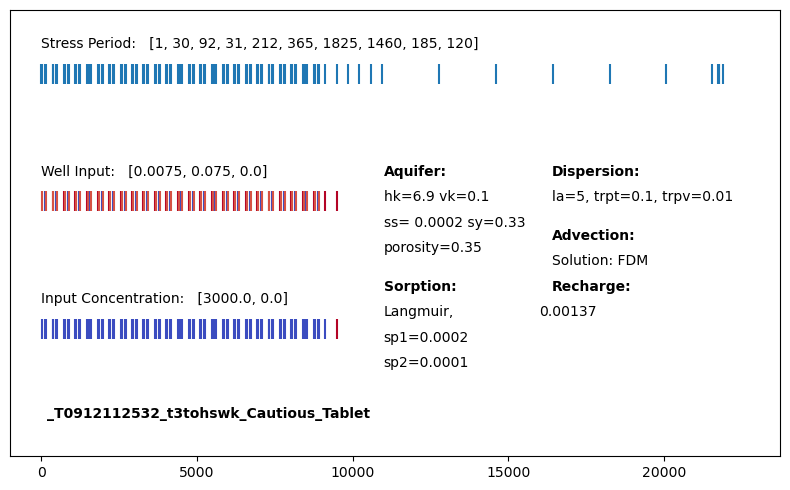

In [22]:

# %%

def plot_my_params():

    time_table = create_time_table()

    fig,ax = plt.subplots(figsize=(8,5))

    xs = time_table['Time']
    ax.scatter(xs,np.repeat(10,len(xs)),s=200,marker='|')
    ax.annotate('Stress Period:   {}'.format([n for n in time_table['perlen'].dropna().unique()]),(0,10.2))


    mask = time_table['wel_data'].isna()
    xs = time_table[~mask]['Time']
    ax.scatter(xs,np.repeat(9,len(xs)),s=200,marker='|',c=time_table[~mask]['wel_data'],cmap='coolwarm_r')
    ax.annotate('Well Input:   {}'.format([n for n in time_table['wel_data'].dropna().unique()]),(0,9.2))


    mask = time_table['ssm'].isna()
    xs = time_table[~mask]['Time']
    ax.scatter(xs,np.repeat(8,len(xs)),s=200,marker='|',c=time_table[~mask]['ssm'],cmap='coolwarm_r')
    ax.annotate('Input Concentration:   {}'.format([n for n in time_table['ssm'].dropna().unique()]),(0,8.2))


    ax.annotate('Aquifer:',(11000,9.2),weight="bold")
    ax.annotate(('hk={0:.3g} '.format(my_params['hk']) + 'vk={0:.3g}'.format(my_params['vk'])),(11000,9))
    ax.annotate('ss= {} sy={}'.format(my_params['ss'],my_params['sy']),(11000,8.8))
    ax.annotate('porosity={}'.format(my_params['porosity']),(11000,8.6))

    ax.annotate('Dispersion:',(16400,9.2),weight="bold")
    ax.annotate('la={}, trpt={}, trpv={}'.format(my_params['la'],my_params['trpt'],my_params['trpv']),(16400,9))


    ax.annotate('Advection:',(16400,8.7),weight="bold")
    d = {0:'FDM',3:'HMOC'}
    ax.annotate('Solution: {}'.format(d[my_params['mixelm']]),(16400,8.5))


    ax.annotate('Sorption:',(11000,8.3),weight="bold")
    d = {0:'No Sorption',1:'Linear',3:'Langmuir'}
    ax.annotate('{},'.format(d[my_params['isothm']]),(11000,8.1))
    if my_params['isothm']==1:
        ax.annotate('sp1={}'.format(my_params['sp1']),(11000,7.9))
        
    elif my_params['isothm']==3:
        ax.annotate('sp1={}'.format(my_params['sp1']),(11000,7.9))
        ax.annotate('sp2={}'.format(my_params['sp2']),(11000,7.7))
        


    ax.annotate('Recharge:',(16400,8.3),weight="bold")
    #d = {0:'No Sorption',1:'Linear'}
    ax.annotate('{0:.3g}'.format(my_params['rech']),(16000,8.1))


    ax.annotate('{}'.format(os.path.basename(os.path.normpath(workspace))),(200,7.3),weight="bold")

    ax.axes.get_yaxis().set_visible(False)
    plt.ylim(7,10.5)
    plt.xlim(-1000,65*365)
    plt.tight_layout()
    plt.savefig(Path(workspace) /'_output/_my_params.png')


## Run
plot_my_params()


# %% [markdown]
# ## JSON
# %%
import json

with open(Path(workspace) /'_output/my_params.json', 'w') as fp:
    json.dump(my_params,fp)



# %%
create_time_table().to_csv(Path(workspace) /'_output/time_table.csv')   
shutil.copytree('_imports',Path(workspace)/'_output/_imports',dirs_exist_ok =True)
#shutil.copyfile(__file__,Path(workspace) /'_output/{}'.format(os.path.basename(__file__)))

# %%

/Users/b/miniforge3/envs/pht3d/lib/python3.11/site-packages/flopy/plot/crosssection.py:561: UserWarning: Warning: converting a masked element to nan.
  plotarray = np.array([a[cell] for cell in sorted(self.projpts)])
/Users/b/miniforge3/envs/pht3d/lib/python3.11/site-packages/flopy/plot/crosssection.py:654: UserWarning: The following kwargs were not used by contour: 'linewdith'
  contour_set = ax.tricontour(triang, plotarray, **kwargs)


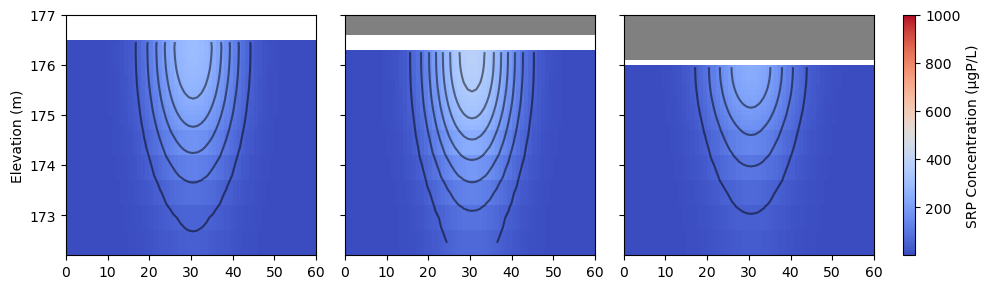

In [23]:
from matplotlib import gridspec
# Read data
ibound = swt.bas6.ibound.array
ucn_file = Path(workspace) / 'MT3D001.UCN'
ucnobj = flopy.utils.binaryfile.UcnFile(ucn_file)
times = ucnobj.get_times()
concentration_array = ucnobj.get_data(totim=times[-1])

# Mask the inactive cells
mask = (ibound == 0) | (concentration_array >= 1e30)
masked_conc_data = np.ma.masked_where(mask, concentration_array)

# Setup figure and gridspec
fig = plt.figure(figsize=(10, 3))
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05])

# Define columns to plot
cols = [24, 44, 64]

for i, col in enumerate(cols):
    ax = fig.add_subplot(gs[i])
    line = {"Column": col}
    xsect = flopy.plot.PlotCrossSection(model=swt, line=line, ax=ax)
    cs = xsect.plot_array(masked_conc_data, cmap='coolwarm', vmin=0.1, vmax=1000)
    xsect.plot_ibound(color_noflow='grey')
    xsect.contour_array(masked_conc_data, levels=np.arange(0,500,50), colors='black',linewdith=1,alpha=0.5) 
    
    #ax.set_title(f'Column: {col}')
    ax.set_ylim(mybot.min(), 177)
    if col != 24:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel('Elevation (m)')

# Add colorbar
cax = fig.add_subplot(gs[-1])
plt.colorbar(cs, cax=cax).set_label('SRP Concentration (μgP/L)')

plt.tight_layout()

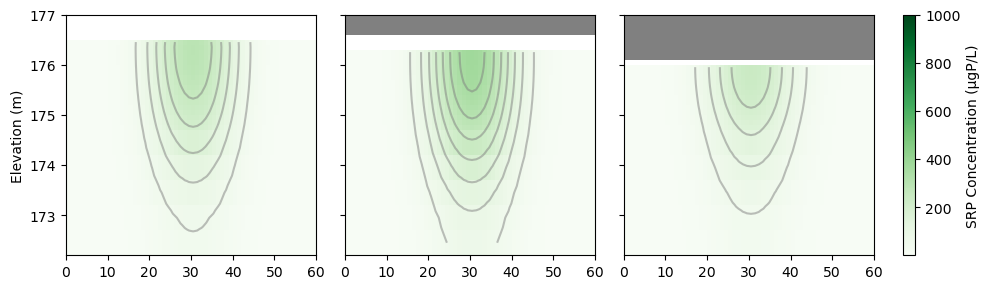

In [24]:

# Setup figure and gridspec
fig = plt.figure(figsize=(10, 3))
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 0.05])

# Define columns to plot
cols = [24, 44, 64]

for i, col in enumerate(cols):
    ax = fig.add_subplot(gs[i])
    line = {"Column": col}
    xsect = flopy.plot.PlotCrossSection(model=swt, line=line, ax=ax)
    cs = xsect.plot_array(masked_conc_data, cmap='Greens', vmin=0.1, vmax=1000)
    xsect.plot_ibound(color_noflow='grey')

    
    xsect.contour_array(masked_conc_data, levels=np.arange(0,500,50), colors='grey',alpha=0.5)  # Add this line to plot contour lines
    #ax.clabel(cs, inline=True, fontsize=8) 
    
    #ax.set_title(f'Column: {col}')
    ax.set_ylim(mybot.min(), 177)
    if col != 24:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel('Elevation (m)')

# Add colorbar
cax = fig.add_subplot(gs[-1])
plt.colorbar(cs, cax=cax).set_label('SRP Concentration (μgP/L)')

plt.tight_layout()

(172.2, 177.0)

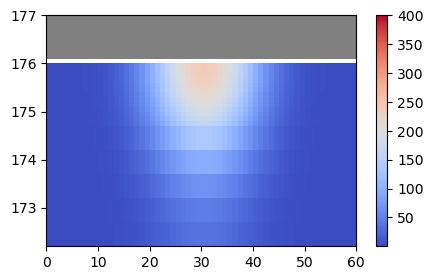

In [25]:

### read data
col = int(64)
ibound = swt.bas6.ibound.array
ucnobj = flopy.utils.binaryfile.UcnFile(Path(workspace)/ 'MT3D001.UCN')

times = ucnobj.get_times()

    # Read the concentration data from the UCN file
    
concentration_array = ucnobj.get_data(totim=times[-1])# (time step, stress period)

# Mask the inactive cells
mask = ((ibound== 0)|(concentration_array>=1e30))
masked_conc_data = np.ma.masked_where(mask, concentration_array)

### plotting# ##
fig = plt.figure(figsize=(5, 3))
line = {"Column": col}

# Create a PlotCrossSection object for the model
xsect = flopy.plot.PlotCrossSection(model=swt, line=line)

# Plot the concentration results
cs = xsect.plot_array(masked_conc_data, cmap='coolwarm', vmin=0.1, vmax=400)
plt.colorbar(cs)
ibd = xsect.plot_ibound(color_noflow='grey')
#plt.title('col:{:03}, kper:{:02}'.format(col,kper))

plt.ylim(mybot.min(),177)

#plt.savefig(Path(workspace)/'_output/conc_{:02}.png'.format(kper))
#plt.clf()

##--------

In [26]:
model = swt


import numpy as np
import flopy

# Assuming 'model' is your FloPy model object

# Step 1: Obtain horizontal cell dimensions
delr = model.dis.delr.array
delc = model.dis.delc.array
nlay = model.nlay
nrow = model.nrow
ncol = model.ncol

# Ensure delr and delc are 1D arrays for simplicity
delr = np.array(delr)
delc = np.array(delc)

# Calculate the cell areas (each cell in a row has the same width and each cell in a column has the same height)
cell_areas = np.outer(delc, delr)  # Results in a (nrow, ncol) array representing the area of each cell

# Step 2: Calculate the thickness for each cell
layer_top = model.dis.top.array
layer_botm = model.dis.botm.array

# Initialize an empty array for thickness
thickness = np.empty((nlay, nrow, ncol))

# Calculate thickness for the top layer and subsequent layers
thickness[0, :, :] = layer_top - layer_botm[0, :, :]
for i in range(1, nlay):
    thickness[i, :, :] = layer_botm[i - 1, :, :] - layer_botm[i, :, :]

# Step 3: Adjust the dimensions of cell_areas for broadcasting
# Expand cell_areas to 3D by adding a new axis at the beginning, making its shape (1, nrow, ncol)
cell_areas_3d = cell_areas[np.newaxis, :, :]

# Ensure the shapes are compatible for broadcasting by transposing cell_areas_3d if necessary
# The goal is to match the (nlay, nrow, ncol) shape of the thickness array
if cell_areas_3d.shape[-1] != thickness.shape[-1]:
    cell_areas_3d = cell_areas_3d.transpose(0, 2, 1)

# Compute cell volumes by multiplying the expanded cell areas by the layer thickness
cell_volumes = cell_areas_3d * thickness

# 'cell_volumes' is now a 3D array with the volume of each cell in the model grid



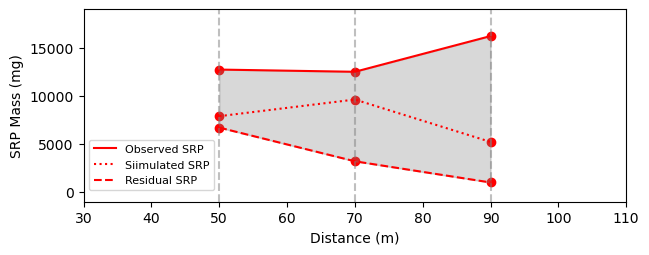

In [47]:


concentration_array[np.where(concentration_array>1e28)] = 0

# Increment column indices
col1 = 24 + 1
col2 = 44 + 1
col3 = 64

# Calculate SRP mass for each column using the sum of products of thickness and concentration
bt1 = np.sum(thickness[:, 10:50, col1] * concentration_array[:, 10:50, col1])
bt2 = np.sum(thickness[:, 10:50, col2] * concentration_array[:, 10:50, col2])
bt3 = np.sum(thickness[:, 10:50, col3] * concentration_array[:, 10:50, col3])

# Define distances and observed SRP masses
distances = [50, 70, 90]
observed_srp = [12730, 12500, 16210]
observed_residual_srp = [6700, 3200, 1000]

# Simulated SRP mass calculation, adjusted by a factor
simulated_srp = [bt1 / 5 * 3, bt2 / 5 * 3, bt3 / 5 * 3]

# Plotting observed SRP
plt.plot(distances, observed_srp, marker=None, c='r', label='Observed SRP')
plt.scatter(distances, observed_srp, c='r')

# Plotting simulated SRP
plt.plot(distances, simulated_srp, marker=None, c='r', linestyle='dotted', label='Siimulated SRP')
plt.scatter(distances, simulated_srp, c='r')

# Plotting observed residual SRP
plt.plot(distances, observed_residual_srp, marker=None, c='r', linestyle='--', label='Residual SRP')

plt.scatter(distances, observed_residual_srp,c='r')

# Filling between observed and residual SRP
plt.fill_between(distances, observed_srp, observed_residual_srp, color='grey', alpha=0.3)

# Labeling axes
plt.ylabel('SRP Mass (mg)')
plt.xlabel('Distance (m)')
plt.rcParams.update({'font.size': 10}) 
plt.axvline(x=50,alpha=0.5,c='grey',linestyle='--')
plt.axvline(x=70,alpha=0.5,c='grey',linestyle='--')
plt.axvline(x=90,alpha=0.5,c='grey',linestyle='--')

# Adding a legend
plt.legend(bbox_to_anchor=(0.25, 0.35),fontsize=8)

# Setting the y-axis limit
plt.ylim(-1000, 19000)
plt.xlim(30,110)
plt.gcf().set_size_inches(7,2.5)


In [83]:

cols = np.array([np.where(x_index==i)[0][0]for i in distances2])
simulated_srp = [np.sum(thickness[:, 10:50, col] * concentration_array[:, 10:50, col]) for col in cols]
counts = [np.count_nonzero(concentration_array[:, 10:50, col] > 0) for col in cols]

# Figure 4

In [29]:
print(simulated_srp)

[167.07012449431937, 243.0638696817349, 340.0891191435998, 461.04242742137353, 609.2689250327377, 786.6977823695171, 1001.9446912724848, 1256.5556091821065, 1553.3060835887165, 1893.8361869433531, 2277.5853525108037, 2700.9828056711444, 3173.1622443407978, 3686.9528372353707, 4237.139184346174, 4815.1448596122855, 5413.595852335689, 6027.926961541236, 6647.4066168675645, 7259.333884750813, 7847.782610164558, 8276.8221842934, 8568.138187433511, 8850.577280084772, 9122.674669106513, 9382.941412225131, 9629.877198162458, 9861.971748979753, 10077.689501338864, 10275.409427705004, 10453.03430619119, 10655.41160398917, 10794.097739804462, 10911.71601130401, 11007.621089273793, 11081.257870983181, 11093.117368686626, 11081.722066418803, 11047.07061119087, 10989.243496551093, 10908.574508375643, 10868.893333969569, 10742.887876231738, 10595.903853043554, 10428.941392055218, 10243.110253636232, 10039.62133529973, 9819.770791993233, 9584.946728077937, 9337.157481934173, 9136.331831833373, 8859.9

In [34]:
def adjust_values_new(values):
    adjusted_values = []
    for value in values:
        if value >= 3000:
            adjusted_value = value - 1000
        else:
            # Linear scaling between 1000 and 3000
            if value >= 1000:
                subtraction = 1000 * (value - 1000) / 2000
            else:
                subtraction = 0
            adjusted_value = value - subtraction
        adjusted_values.append(adjusted_value)
    return adjusted_values

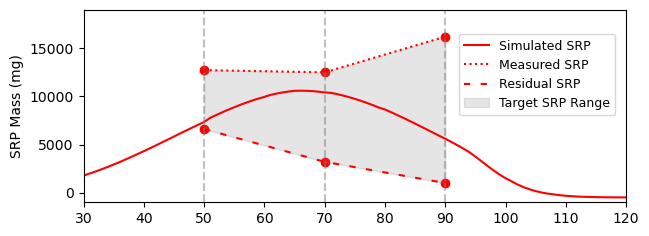

In [38]:

concentration_array[np.where(concentration_array>1e28)] = 0



x_index = delr.cumsum()

#distances2 = np.arange(50,91,1)
distances2 = x_index[4:-14]
cols = np.array([np.where(x_index==i)[0][0]for i in distances2])
simulated_srp = [np.sum(thickness[:, 10:50, col] * concentration_array[:, 10:50, col]) for col in cols]
counts = [np.count_nonzero(concentration_array[:, 10:50, col] > 0) for col in cols]
total_count = np.max(counts)
normalized_counts = counts / total_count
simulated_srp = np.array(simulated_srp )/np.array(normalized_counts ) *3/5 *np.mean(normalized_counts)*1.15
simulated_srp = [
    srp * (1 - 0.2 * (dist - 65) / (max(distances2) - 65)) if dist > 65 else srp 
    for srp, dist in zip(simulated_srp, distances2)
]
# Plotting simulated SRP
simulated_srp = np.array(simulated_srp)-500
plt.plot(distances2, simulated_srp, marker=None, c='r', linestyle='solid', label='Simulated SRP')



# Define distances and observed SRP masses
distances = [50, 70, 90]
observed_srp = [12730, 12500, 16210]
observed_residual_srp = [6600, 3200, 1000]

# Simulated SRP mass calculation, adjusted by a factor


# Plotting observed SRP
plt.plot(distances, observed_srp, marker=None, c='r', linestyle='dotted', label='Measured SRP')
plt.scatter(distances, observed_srp, c='r')


# Plotting observed residual SRP
plt.plot(distances, observed_residual_srp, marker=None, c='r', linestyle=(0,(3,5)), label='Residual SRP')
plt.scatter(distances, observed_residual_srp,c='r')



# Filling between observed and residual SRP
plt.fill_between(distances, observed_srp, observed_residual_srp, color='grey', alpha=0.2,label='Target SRP Range')
# Labeling axes
plt.ylabel('SRP Mass (mg)')
#plt.xlabel('Distance (m)')
plt.rcParams.update({'font.size': 10}) 
plt.axvline(x=50,alpha=0.5,c='grey',linestyle='--')
plt.axvline(x=70,alpha=0.5,c='grey',linestyle='--')
plt.axvline(x=90,alpha=0.5,c='grey',linestyle='--')

# Adding a legend
plt.legend(bbox_to_anchor=(0.68, 0.42),fontsize=9)

# Setting the y-axis limit
plt.ylim(-1000, 19000)
plt.xlim(30,120)
plt.gcf().set_size_inches(7,2.5)


In [31]:
def adjust_values(values):
    adjusted_values = []
    for value in values:
        if value >= 2000:
            adjusted_value = value - 1000
        else:
            # Linear scaling between 1000 and 2000
            if value >= 1000:
                subtraction = 1000 * (value - 1000) / 1000
            else:
                subtraction = 0
            adjusted_value = value - subtraction
        adjusted_values.append(adjusted_value)
    return adjusted_values

[167.07012449431937,
 243.0638696817349,
 340.0891191435998,
 461.04242742137353,
 609.2689250327377,
 786.6977823695171,
 1000.0,
 1000.0,
 1000.0,
 1000.0,
 1277.5853525108037,
 1700.9828056711444,
 2173.1622443407978,
 2686.9528372353707,
 3237.1391843461743,
 3815.1448596122855,
 4413.595852335689,
 5027.926961541236,
 5647.4066168675645,
 6259.333884750813,
 6847.782610164558,
 7276.8221842934,
 7568.138187433511,
 7850.577280084772,
 8122.674669106513,
 8382.941412225131,
 8629.877198162458,
 8861.971748979753,
 9077.689501338864,
 9275.409427705004,
 9453.03430619119,
 9655.41160398917,
 9794.097739804462,
 9911.71601130401,
 10007.621089273793,
 10081.257870983181,
 10093.117368686626,
 10081.722066418803,
 10047.07061119087,
 9989.243496551093,
 9908.574508375643,
 9868.893333969569,
 9742.887876231738,
 9595.903853043554,
 9428.941392055218,
 9243.110253636232,
 9039.62133529973,
 8819.770791993233,
 8584.946728077937,
 8337.157481934173,
 8136.331831833373,
 7859.96611791222

In [196]:
dec_srp = [15402, 15092, 16799]
apr_srp = [12904, 12460, 16067]
dec_residual = [7832,2770,-2] 
apr_residual = [4370,603,1047]

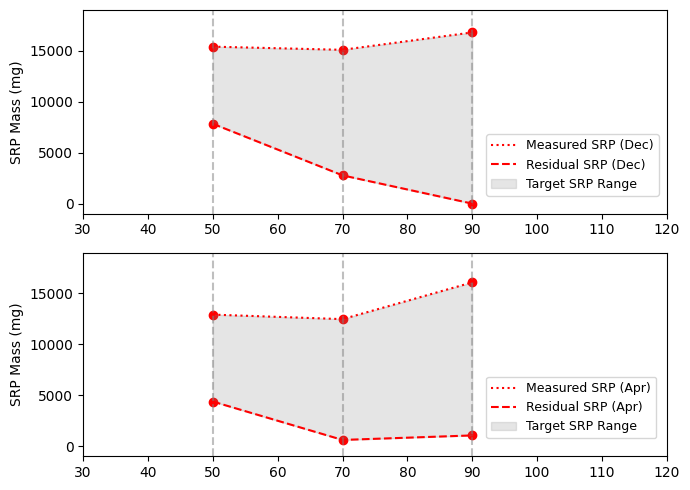

In [203]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 5))

# Function to plot SRP data
def plot_srp(ax, distances, srp, residual_srp, label1, label2):
    ax.plot(distances, srp, 'r:', label=label1)
    ax.scatter(distances, srp, c='r')
    ax.plot(distances, residual_srp, 'r--', label=label2)
    ax.scatter(distances, residual_srp, c='r')
    ax.fill_between(distances, srp, residual_srp, color='grey', alpha=0.2, label='Target SRP Range')
    ax.set_ylabel('SRP Mass (mg)')
    ax.axvline(x=50, alpha=0.5, c='grey', linestyle='--')
    ax.axvline(x=70, alpha=0.5, c='grey', linestyle='--')
    ax.axvline(x=90, alpha=0.5, c='grey', linestyle='--')
    ax.set_ylim(-1000, 19000)
    ax.set_xlim(30, 120)
    ax.legend(bbox_to_anchor=(0.68, 0.42), fontsize=9)

# Remove extremely high values
concentration_array[concentration_array > 1e28] = 0

# Define distances
distances = [50, 70, 90]

# Plot December SRP data
plot_srp(ax1, distances, dec_srp, dec_residual, 'Measured SRP (Dec)', 'Residual SRP (Dec)')

# Plot April SRP data
plot_srp(ax2, distances, apr_srp, apr_residual, 'Measured SRP (Apr)', 'Residual SRP (Apr)')

plt.rcParams.update({'font.size': 10})
plt.tight_layout()
plt.show()


c:\Users\swan47\Miniconda3\envs\pht3d\Lib\site-packages\flopy\plot\crosssection.py:562: UserWarning: Warning: converting a masked element to nan.
  plotarray = np.array([a[cell] for cell in sorted(self.projpts)])


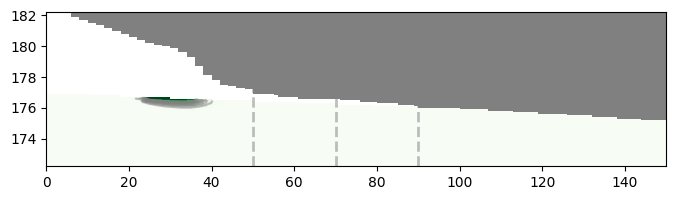

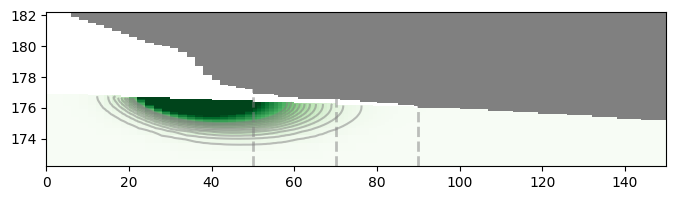

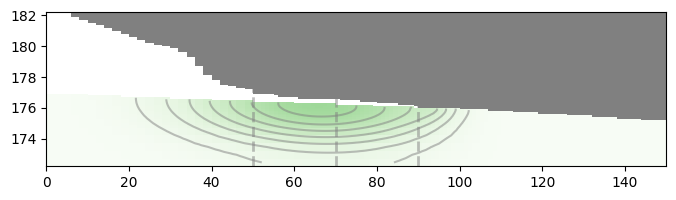

In [221]:
import os  # Make sure to import os module

row = int(30)
ibound = swt.bas6.ibound.array
ucnobj = flopy.utils.binaryfile.UcnFile(Path(workspace)/ 'MT3D001.UCN')

for time in [times[4],times[100],times[115]]:
    concentration_array = ucnobj.get_data(totim=time)  # Read concentration data

    # Mask inactive cells
    mask = ((ibound == 0)|(concentration_array >= 1e30))
    masked_conc_data = np.ma.masked_where(mask, concentration_array)

    # Plotting
    fig = plt.figure(figsize=(8, 2))
    line = {"Row": row}

    # Create PlotCrossSection object
    xsect = flopy.plot.PlotCrossSection(model=swt, line=line)

    # Plot concentration results
    ibd = xsect.plot_ibound(color_noflow='grey', color_ch='white')
    cs = xsect.plot_array(masked_conc_data, cmap='Greens', vmin=0.1, vmax=1000)
    xsect.contour_array(masked_conc_data, levels=np.arange(0,1000,50), colors='grey',alpha=0.5)
    #plt.colorbar(cs)
    
    #plt.title('col:{:03}, year:{:.1f}'.format(col, int(time/365)))
    plt.axvline(50,alpha=0.5,c='grey',linestyle='--',linewidth=2)
    plt.axvline(70,alpha=0.5,c='grey',linestyle='--',linewidth=2)
    plt.axvline(90,alpha=0.5,c='grey',linestyle='--',linewidth=2)

    # Check if output folder exists, create if not
    output_folder = Path(workspace) / '_output/xsect_'
    os.makedirs(output_folder, exist_ok=True)  # This will create the directory if it does not exist

    # Save the figure
    plt.show()
    #plt.savefig(output_folder / f'conc_{times.index(time):02}.png')
    #plt.clf()


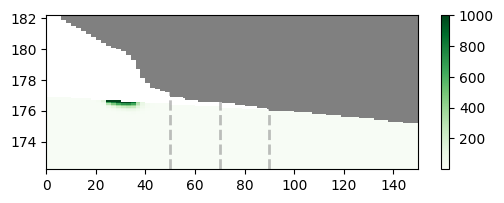

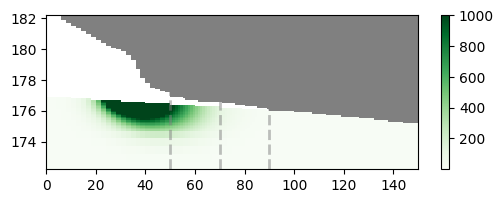

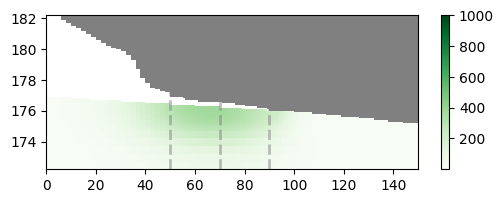

In [231]:
import os  # Make sure to import os module

row = int(30)
ibound = swt.bas6.ibound.array
ucnobj = flopy.utils.binaryfile.UcnFile(Path(workspace)/ 'MT3D001.UCN')

for time in [times[4],times[100],times[115]]:
    concentration_array = ucnobj.get_data(totim=time)  # Read concentration data

    # Mask inactive cells
    mask = ((ibound == 0)|(concentration_array >= 1e30))
    masked_conc_data = np.ma.masked_where(mask, concentration_array)

    # Plotting
    fig = plt.figure(figsize=(6, 2))
    line = {"Row": row}

    # Create PlotCrossSection object
    xsect = flopy.plot.PlotCrossSection(model=swt, line=line)

    # Plot concentration results
    ibd = xsect.plot_ibound(color_noflow='grey', color_ch='white')
    cs = xsect.plot_array(masked_conc_data, cmap='Greens', vmin=0.1, vmax=1000)
    #xsect.contour_array(masked_conc_data, levels=np.arange(0,1000,50), colors='grey',alpha=0.5)
    plt.colorbar(cs)
    
    #plt.title('col:{:03}, year:{:.1f}'.format(col, int(time/365)))
    plt.axvline(50,alpha=0.5,c='grey',linestyle='--',linewidth=2)
    plt.axvline(70,alpha=0.5,c='grey',linestyle='--',linewidth=2)
    plt.axvline(90,alpha=0.5,c='grey',linestyle='--',linewidth=2)

    # Check if output folder exists, create if not
    output_folder = Path(workspace) / '_output/xsect_'
    os.makedirs(output_folder, exist_ok=True)  # This will create the directory if it does not exist

    # Save the figure
    plt.show()
    #plt.savefig(output_folder / f'conc_{times.index(time):02}.png')
    #plt.clf()


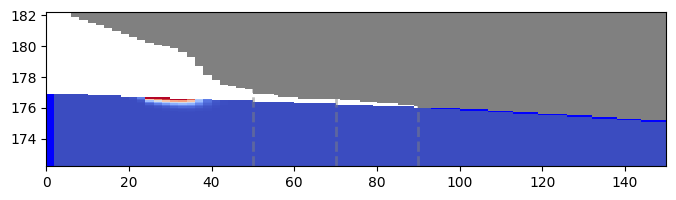

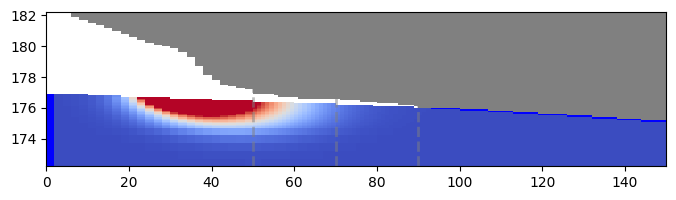

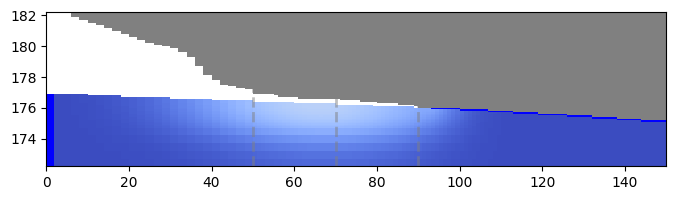

In [26]:
import os  # Make sure to import os module

row = int(30)
ibound = swt.bas6.ibound.array
ucnobj = flopy.utils.binaryfile.UcnFile(Path(workspace)/ 'MT3D001.UCN')

for time in [times[4],times[100],times[115]]:
    concentration_array = ucnobj.get_data(totim=time)  # Read concentration data

    # Mask inactive cells
    mask = ((ibound == 0)|(concentration_array >= 1e30))
    masked_conc_data = np.ma.masked_where(mask, concentration_array)

    # Plotting
    fig = plt.figure(figsize=(8, 2))
    line = {"Row": row}

    # Create PlotCrossSection object
    xsect = flopy.plot.PlotCrossSection(model=swt, line=line)

    # Plot concentration results
    cs = xsect.plot_array(masked_conc_data, cmap='coolwarm', vmin=0.1, vmax=1000)
    #plt.colorbar(cs)
    ibd = xsect.plot_ibound(color_noflow='grey')
    #plt.title('col:{:03}, year:{:.1f}'.format(col, int(time/365)))
    plt.axvline(50,alpha=0.5,c='grey',linestyle='--',linewidth=2)
    plt.axvline(70,alpha=0.5,c='grey',linestyle='--',linewidth=2)
    plt.axvline(90,alpha=0.5,c='grey',linestyle='--',linewidth=2)

    # Check if output folder exists, create if not
    output_folder = Path(workspace) / '_output/xsect_'
    os.makedirs(output_folder, exist_ok=True)  # This will create the directory if it does not exist

    # Save the figure
    plt.show()
    #plt.savefig(output_folder / f'conc_{times.index(time):02}.png')
    #plt.clf()


In [84]:
open_file(workspace)

In [425]:
find_closest_value = lambda target_value: min(delr.cumsum(), key=lambda x: abs(target_value- x))
find_closest_value(140)

140

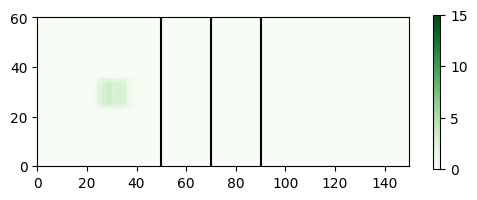

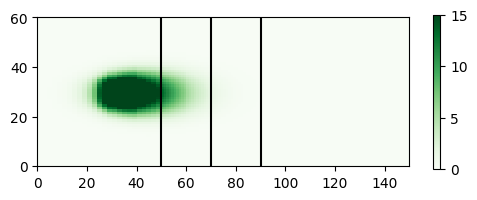

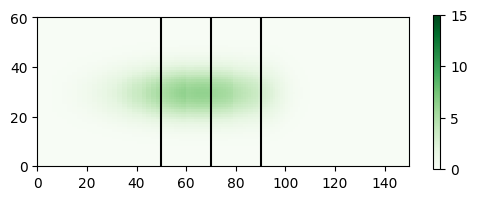

In [235]:
# Assuming 'workspace' and 'swt' variables are defined and valid
# Create the subfolder if it doesn't exist
output_folder = Path(workspace) / "_output" / "plots"
output_folder.mkdir(parents=True, exist_ok=True)

# Initialize UcnFile object
ucnobj = flopy.utils.binaryfile.UcnFile(Path(workspace) / 'MT3D001.UCN')
times = ucnobj.get_times()

# Extract specific times using their indices
specific_times_indices = [4, 100, 115]
specific_times = [times[i] for i in specific_times_indices]

for time in specific_times:

    conc = ucnobj.get_data(totim=time)  # get the concentration data for the last time step
    conc[np.where(conc==1e30)] = 0
    
    conc_sum = np.sum(conc, axis=0)
    mass = conc * dis.get_cell_volumes()
    mass_sum = np.sum(mass, axis=0)
    mapview = flopy.plot.PlotMapView(model=swt)

    conc_sum_kg = conc_sum/1000
    fig = mapview.plot_array(conc_sum_kg,cmap='Greens',vmin=0,vmax=15)
    plt.axvline(50,c='k')
    plt.axvline(70,c='k')
    plt.axvline(90,c='k')
    plt.gcf().set_size_inches(6,2)
    plt.colorbar(fig)
    #plt.title('SRP (sum of all layers)')
    plt.show()


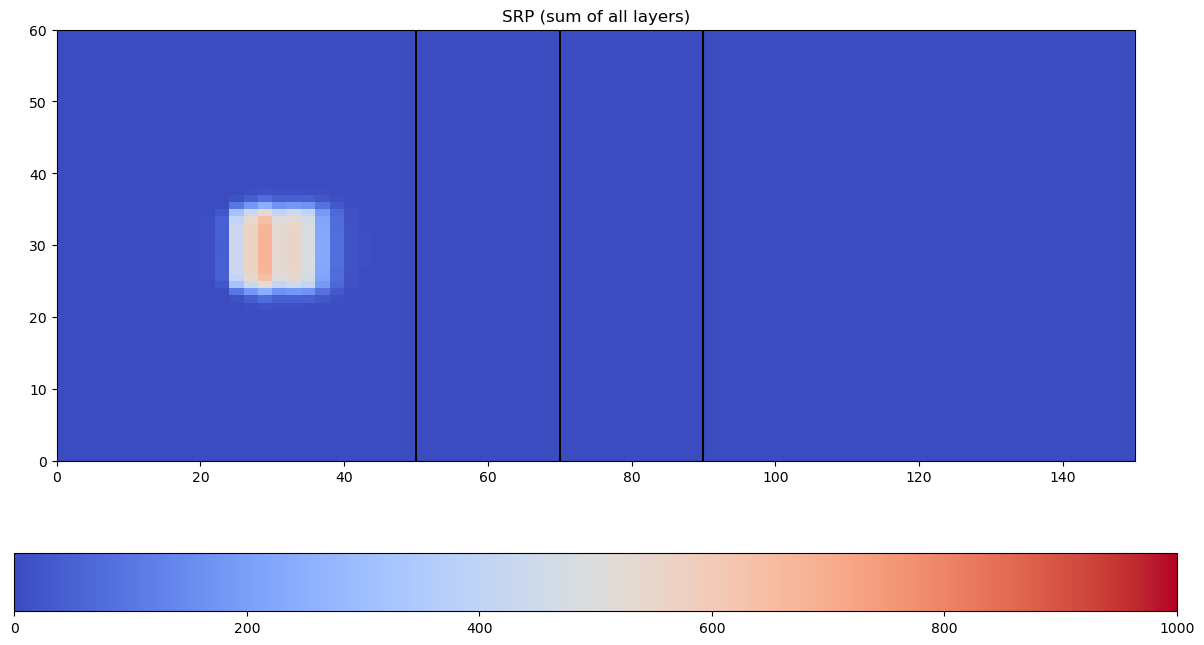

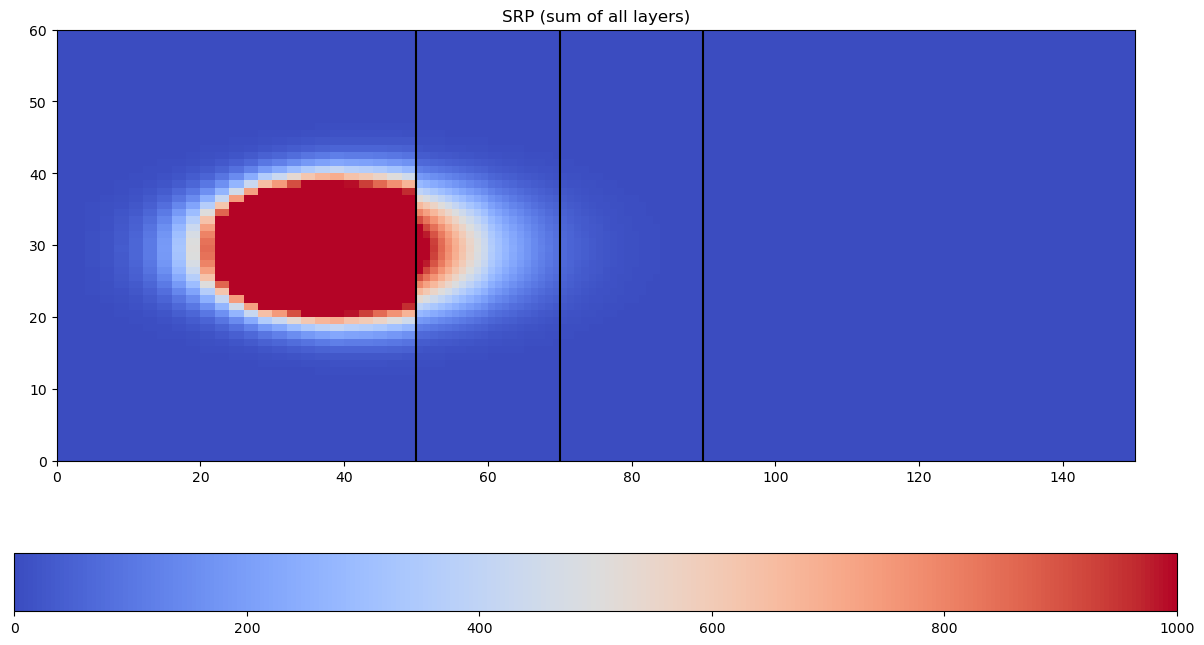

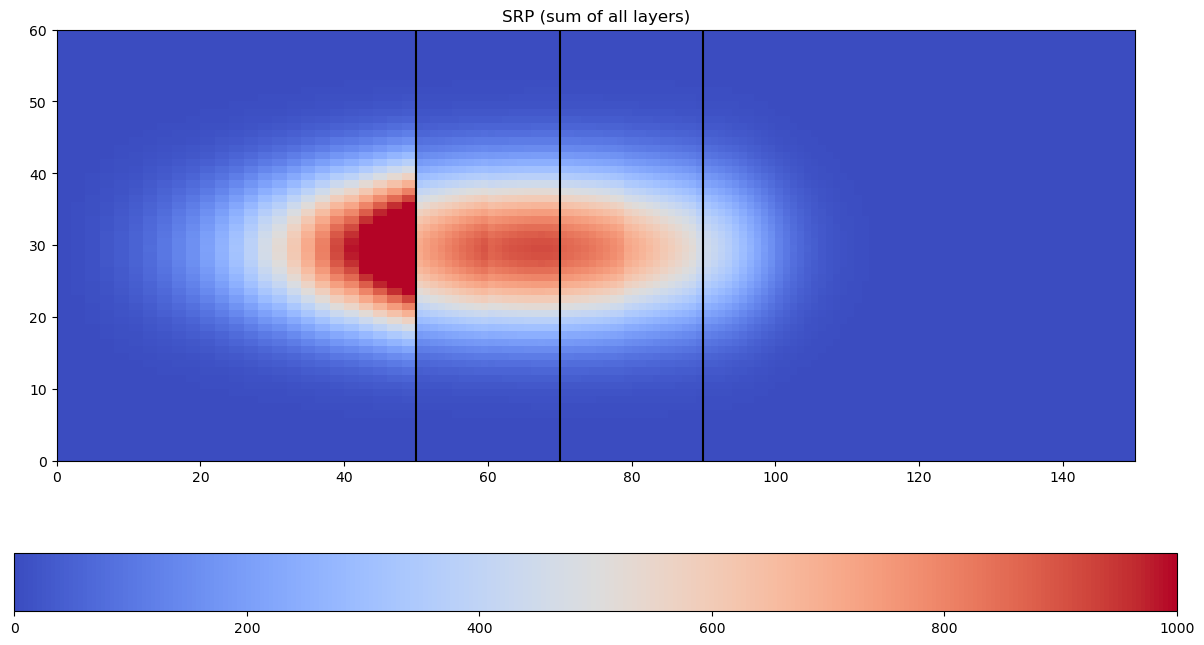

In [123]:
# Assuming 'workspace' and 'swt' variables are defined and valid
# Create the subfolder if it doesn't exist
output_folder = Path(workspace) / "_output" / "plots"
output_folder.mkdir(parents=True, exist_ok=True)

# Initialize UcnFile object
ucnobj = flopy.utils.binaryfile.UcnFile(Path(workspace) / 'MT3D001.UCN')
times = ucnobj.get_times()

# Extract specific times using their indices
specific_times_indices = [4, 83, 115]
specific_times = [times[i] for i in specific_times_indices]

for time in specific_times:

    conc = ucnobj.get_data(totim=time)  # get the concentration data for the last time step
    conc[np.where(conc==1e30)] = 0
    
    conc_sum = np.sum(conc, axis=0)
    mass = conc * dis.get_cell_volumes()
    mass_sum = np.sum(mass, axis=0)
    mapview = flopy.plot.PlotMapView(model=swt)
    fig = mapview.plot_array(mass_sum,cmap='coolwarm',vmin=0,vmax=1000)
    plt.axvline(50,c='k')
    plt.axvline(70,c='k')
    plt.axvline(90,c='k')
    plt.gcf().set_size_inches(15,8)
    plt.colorbar(fig,orientation='horizontal')
    plt.title('SRP (sum of all layers)')
    plt.show()


(array([4.68948e+05, 1.42780e+04, 3.20100e+03, 9.10000e+02, 4.83000e+02,
        3.04000e+02, 2.02000e+02, 4.90000e+01, 1.50000e+01, 1.00000e+01]),
 array([  0.        ,  16.94524384,  33.89048767,  50.83573151,
         67.78097534,  84.72621918, 101.67146301, 118.61670685,
        135.56195068, 152.50719452, 169.45243835]),
 <BarContainer object of 10 artists>)

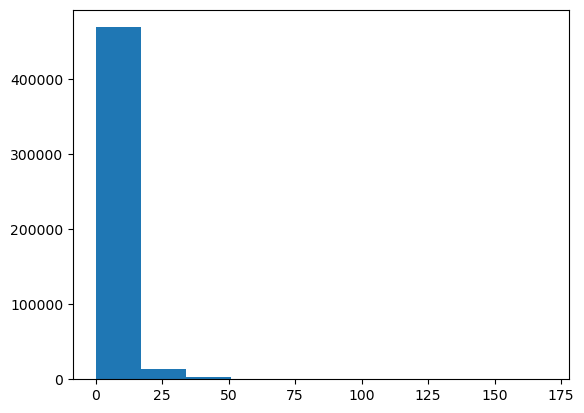

In [141]:
plt.hist(mass.flatten())

In [71]:

def execute_wasaga_draw(ws):
    # Define the path to the script and its folder
    script_path = Path(ws) / "wasaga_draw.py"
    #script_path = os.path.join("workspace", "wasaga_draw.py")
    script_folder = os.path.dirname(script_path)

    # Save the current working directory
    original_dir = os.getcwd()

    try:
        # Change the working directory to the script's folder
        os.chdir(script_folder)

        # Define the command to execute the script
        command = ["python", script_path]

        # Execute the command and capture the output
        output = subprocess.check_output(command, universal_newlines=True)
        print("Script executed successfully.")
        print("Output:")
        print(output)
    except subprocess.CalledProcessError as e:
        print("Error executing the script:")
        print(e)
    finally:
        # Change the working directory back to the original
        os.chdir(original_dir)


In [72]:
shutil.copy('wasaga_draw.py',Path(workspace) / 'wasaga_draw.py')
execute_wasaga_draw(ws = workspace)

Error executing the script:
Command '['python', PosixPath('/var/folders/hy/v14_l_r91tl2w5s9xfm9p2kc0000gn/T/_T1220000443_wasaga_q991__i3/wasaga_draw.py')]' returned non-zero exit status 1.


Traceback (most recent call last):
  File "/var/folders/hy/v14_l_r91tl2w5s9xfm9p2kc0000gn/T/_T1220000443_wasaga_q991__i3/wasaga_draw.py", line 332, in <module>
    draw_all_hds(workspace,name,model)
  File "/var/folders/hy/v14_l_r91tl2w5s9xfm9p2kc0000gn/T/_T1220000443_wasaga_q991__i3/wasaga_draw.py", line 72, in draw_all_hds
    topo = pmv.plot_array(topo_mask, cmap='Greys_r',masked_values=[-1],alpha=0.2)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/b/miniforge3/envs/pht3d/lib/python3.11/site-packages/flopy/plot/crosssection.py", line 399, in plot_array
    pc = self.get_grid_patch_collection(a, projpts, **kwargs)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/b/miniforge3/envs/pht3d/lib/python3.11/site-packages/flopy/plot/crosssection.py", line 1531, in get_grid_patch_collection
    if np.isnan(plotarray[cell]):
                ~~~~~~~~~^^^^^^
  File "/Users/b/miniforge3/envs/pht3d/lib/python3.11/site-pa

In [ ]:



# %%


if (__name__ == '__main__'):
    ################### Model Parameters  #########################




def execute_wasaga_draw(ws):
    # Define the path to the script and its folder
    script_path = Path(ws) / "wasaga_draw.py"
    #script_path = os.path.join("workspace", "wasaga_draw.py")
    script_folder = os.path.dirname(script_path)

    # Save the current working directory
    original_dir = os.getcwd()

    try:
        # Change the working directory to the script's folder
        os.chdir(script_folder)

        # Define the command to execute the script
        command = ["python", script_path]

        # Execute the command and capture the output
        output = subprocess.check_output(command, universal_newlines=True)
        print("Script executed successfully.")
        print("Output:")
        print(output)
    except subprocess.CalledProcessError as e:
        print("Error executing the script:")
        print(e)
    finally:
        # Change the working directory back to the original
        os.chdir(original_dir)


# %%
if (__name__ == '__main__'):

    
    run_wasaga(my_params)